In [1]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from google.colab import drive

In [2]:
class image_data_set(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, index):
        return {'data': self.data[index], 'label': self.labels[index]}

In [3]:
def print_data_analysis(present_lighting_sufficient_data, 
                        present_lighting_insufficient_data, 
                        not_present_lighting_sufficient_data, 
                        not_present_lighting_insufficient_data):
  
    subplot = plt.subplot()
    data_lengthes = np.array([
        [len(present_lighting_sufficient_data), len(present_lighting_insufficient_data)], 
        [len(not_present_lighting_sufficient_data), len(not_present_lighting_insufficient_data)]
    ])
    sns.heatmap(data_lengthes, annot=True, fmt='g', cmap='Blues')
    subplot.xaxis.set_ticklabels(['Lighting Sufficient', 'Lighting Not Sufficient'])
    subplot.yaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    plt.show()

def get_image_tensor(file_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    image = Image.open(file_path)
    return transform(image)

def get_data_and_labels(directory_path, label):
    image_tensors, labels = [], []
    for file in os.listdir(directory_path):
        if file.endswith(".JPG"):
            file_path = directory_path + file
            image_tensor = get_image_tensor(file_path)

            image_tensors.append(image_tensor)
            labels.append(label)
            
    return image_tensors, labels

def get_data_for_label(file_pathes, label): 

  all_data, all_labels = [], []
  for file_path in file_pathes:
      data, labels = get_data_and_labels(file_path, label)
      all_data.extend(data)
      all_labels.extend(labels)

  return all_data, all_labels
    
def get_data_sets(present_file_pathes_lighting_sufficient, 
                  present_file_pathes_lighting_insufficient,
                  not_present_file_pathes_lighting_sufficient,
                  not_present_file_pathes_lighting_insufficient): 

    present_ls_data, present_ls_labels = get_data_for_label(present_file_pathes_lighting_sufficient, 1)
    present_lis_data, present_lis_labels = get_data_for_label(present_file_pathes_lighting_insufficient, 1)
    not_present_ls_data, not_present_ls_labels = get_data_for_label(not_present_file_pathes_lighting_sufficient, 0)
    not_present_lis_data, not_present_lis_labels = get_data_for_label(not_present_file_pathes_lighting_insufficient, 0)

    print_data_analysis(present_ls_data, present_lis_data, not_present_ls_data, not_present_lis_data)
    
    ls_data = present_ls_data + not_present_ls_data
    ls_labels = present_ls_labels + not_present_ls_labels

    lis_data = present_lis_data + not_present_lis_data
    lis_labels = present_lis_labels + not_present_lis_labels
    
    ls_training_data, ls_testing_data, ls_training_labels, ls_testing_labels = train_test_split(ls_data, ls_labels)
    lis_training_data, lis_testing_data, lis_training_labels, lis_testing_labels = train_test_split(lis_data, lis_labels)

    training_data = ls_training_data + lis_training_data
    testing_data = ls_testing_data + lis_testing_data
    training_labels = ls_training_labels + lis_training_labels
    testing_labels = ls_testing_labels + lis_testing_labels
    
    print("\nNumber of training photos: " + str(len(training_data)))
    print("Number of testing photos: " + str(len(testing_data)))
    print("Number of lighting sufficient testing photos: " + str(len(ls_testing_data)))
    print("Number of lighting insufficient testing photos: " + str(len(lis_testing_data)))
    
    training_data_set = image_data_set(training_data, training_labels)
    testing_data_set = image_data_set(testing_data, testing_labels)
    ls_testing_data_set = image_data_set(ls_testing_data, ls_testing_labels)
    lis_testing_data_set = image_data_set(lis_testing_data, lis_testing_labels)
    
    return training_data_set, testing_data_set, ls_testing_data_set, lis_testing_data_set

def get_loaders(training_data_set, testing_data_set, ls_testing_data_set, lis_testing_data_set, batch_size):
    training_loader = torch.utils.data.DataLoader(dataset = training_data_set,
                                                  batch_size = batch_size,
                                                  shuffle = True)

    testing_loader = torch.utils.data.DataLoader(dataset = testing_data_set,
                                                 batch_size = batch_size,
                                                 shuffle = True)
    
    ls_testing_loader = torch.utils.data.DataLoader(dataset = ls_testing_data_set,
                                                 batch_size = batch_size,
                                                 shuffle = True)
    
    lis_testing_loader = torch.utils.data.DataLoader(dataset = lis_testing_data_set,
                                                 batch_size = batch_size,
                                                 shuffle = True)
    
    return training_loader, testing_loader, ls_testing_loader, lis_testing_loader

In [4]:
def print_image(image_tensor, prediction):
    if(prediction == 1):
        prediction_string = "Wildlife Present"
    else:
        prediction_string = "No Wildlife Present"

    #Alternative normalized RGB visualization: plt.imshow(image_tensor.cpu().permute(1, 2, 0).numpy())
    plt.imshow(image_tensor[0].cpu(), cmap="gray")
    plt.title("Incorrectly Predicted " + prediction_string) 
    plt.show()

def print_testing_analysis(all_labels, all_predictions, title):
    subplot = plt.subplot()

    cf_matrix = confusion_matrix(all_labels, all_predictions, labels=[1, 0])
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

    subplot.set_xlabel('Predictions')
    subplot.set_ylabel('Labels')
    subplot.set_title(title + ' Testing Confusion Matrix')
    subplot.xaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    subplot.yaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    plt.show()

    accuracy = accuracy_score(all_labels, all_predictions)
    print(title + " Accuracy: " + str(accuracy))

    precision, recall, f_score, support = precision_recall_fscore_support(all_labels, all_predictions, average='binary')
    print(title + " Precision: " + str(precision))
    print(title + " Recall: " + str(recall))
    print(title + " F-Score: " + str(f_score))

def train(model, training_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    num_correct = 0
    for i, data in enumerate(training_loader):
        data, labels = data['data'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        num_correct += (predictions == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    loss = running_loss/len(training_loader.dataset)
    accuracy = num_correct/len(training_loader.dataset)
    return loss, accuracy

def test(model, testing_loader, criterion, print_incorrect_images):
    model.eval()
    running_loss = 0.0
    num_correct = 0
    all_labels, all_predictions = [], []

    for i, data in enumerate(testing_loader):
        data, labels = data['data'].to(device), data['label'].to(device)
        output = model(data)
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        for index, prediction in enumerate(predictions):
            if(prediction == labels[index]):
                num_correct += 1
            elif(print_incorrect_images):
                print_image(data[index], prediction)

        all_labels.extend(labels.cpu())
        all_predictions.extend(predictions.cpu())
    
    loss = running_loss/len(testing_loader.dataset)
    accuracy = num_correct/len(testing_loader.dataset)
    return loss, accuracy, all_labels, all_predictions

In [5]:
def train_and_test(model, training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    for epoch in range(10):
        print("epoch: " + str(epoch))
        
        training_loss, training_accuracy = train(model, training_loader, criterion, optimizer)
        print("training loss: " + str(training_loss) + " and training accuracy: " + str(training_accuracy))
        
        testing_loss, testing_accuracy, _, _ = test(model, testing_loader, criterion, False)
        print("testing loss: " + str(testing_loss) + " and testing accuracy: " + str(testing_accuracy))

    testing_loss, testing_accuracy, labels, predictions = test(model, testing_loader, criterion, True)
    print_testing_analysis(labels, predictions, "Overall")

    testing_loss, testing_accuracy, labels, predictions = test(model, ls_testing_loader, criterion, False)
    print_testing_analysis(labels, predictions, "Lighting Sufficient")

    testing_loss, testing_accuracy, labels, predictions = test(model, lis_testing_loader, criterion, False)
    print_testing_analysis(labels, predictions, "Lighting Insufficient")

In [6]:
def train_and_test_ResNet50(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes):
    print("\nTraining and Testing ResNet50")
    resnet50 = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
    resnet50.fc.out_features = num_classes
    train_and_test(resnet50, training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device)

def train_and_test_ResNet152(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes):
    print("\nTraining and Testing ResNet152")
    resnet152 = models.resnet152(weights = models.ResNet152_Weights.DEFAULT)
    resnet152.fc.out_features = num_classes
    train_and_test(resnet152, training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device)

def train_and_test_ViT_L_16(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes):
    print("\nTraining and Testing Vision Transformer Large 16")
    vit_l_16 = models.vit_l_16(weights = models.ViT_L_16_Weights.DEFAULT)
    train_and_test(vit_l_16, training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device)

#Orchestration

In [7]:
# Use this to connect to Google Drive in Google Colab
drive.mount('/content/drive')

# Use this to unzip file in Google Colab
!unzip -qq drive/MyDrive/manually_labeled_wildlife_data

Mounted at /content/drive


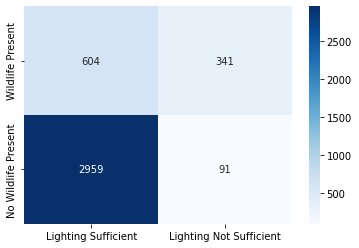


Number of training photos: 2996
Number of testing photos: 999
Number of lighting sufficient testing photos: 891
Number of lighting insufficient testing photos: 108


In [8]:
present_file_pathes_ls = [
  "manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/present/lighting_sufficient/",
  "manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/present/lighting_sufficient/"
]

present_file_pathes_lis = [
  "manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/present/lighting_insufficient/",
  "manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/present/lighting_insufficient/"
]

not_present_file_pathes_ls = [
  "manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/not_present/lighting_sufficient/",
  "manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/not_present/lighting_sufficient/",
]

not_present_file_pathes_lis = [
  "manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/not_present/lighting_insufficient/",
  "manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/not_present/lighting_insufficient/",
]

num_classes = 2
batch_size = 10

training_data_set, testing_data_set, ls_testing_data_set, lis_testing_data_set = get_data_sets(
    present_file_pathes_ls, 
    present_file_pathes_lis,
    not_present_file_pathes_ls,
    not_present_file_pathes_lis
)
training_loader, testing_loader, ls_testing_loader, lis_testing_loader = get_loaders(
    training_data_set, 
    testing_data_set, 
    ls_testing_data_set, 
    lis_testing_data_set, 
    batch_size
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()


Training and Testing ResNet50


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch: 0
training loss: 0.06026654696037299 and training accuracy: 0.8765020026702269
testing loss: 0.014688504980998236 and testing accuracy: 0.948948948948949
epoch: 1
training loss: 0.010153803535540015 and training accuracy: 0.9599465954606141
testing loss: 0.010606203091193785 and testing accuracy: 0.9529529529529529
epoch: 2
training loss: 0.0077310707825776915 and training accuracy: 0.9706275033377837
testing loss: 0.00910880821754688 and testing accuracy: 0.960960960960961
epoch: 3
training loss: 0.005275262829931409 and training accuracy: 0.9799732977303071
testing loss: 0.00799389869934675 and testing accuracy: 0.9629629629629629
epoch: 4
training loss: 0.003983678894702038 and training accuracy: 0.9833110814419226
testing loss: 0.009363318797612508 and testing accuracy: 0.9569569569569569
epoch: 5
training loss: 0.0033269494211582377 and training accuracy: 0.9873164218958611
testing loss: 0.00765987098866326 and testing accuracy: 0.9669669669669669
epoch: 6
training loss: 0.

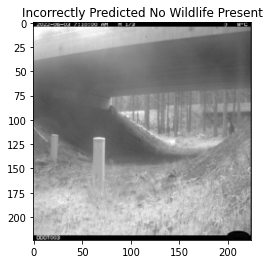

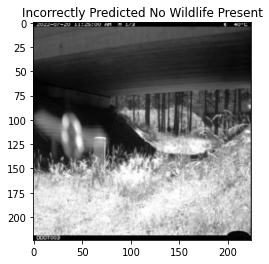

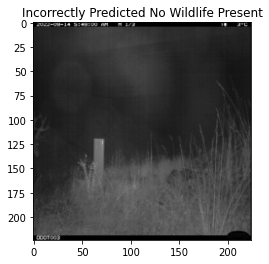

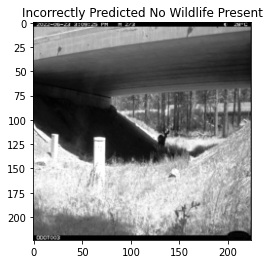

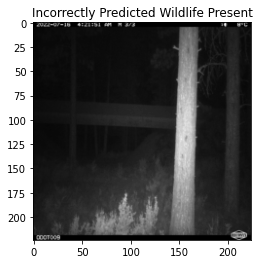

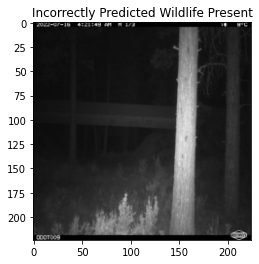

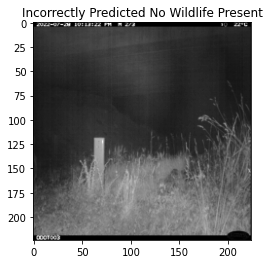

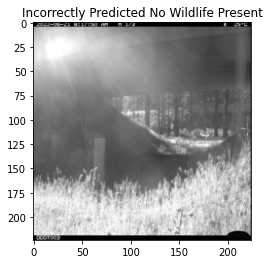

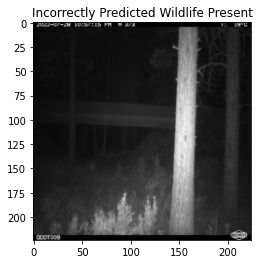

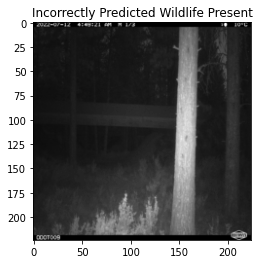

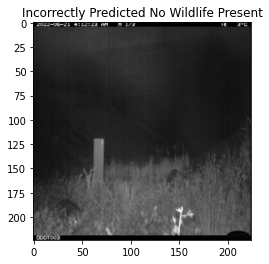

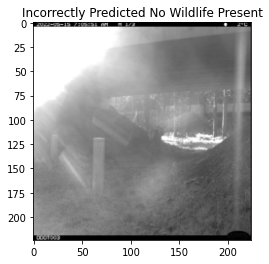

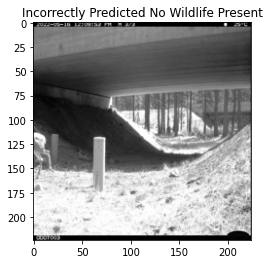

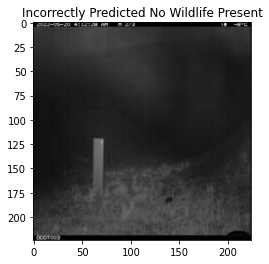

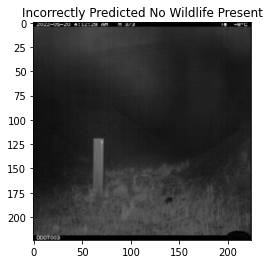

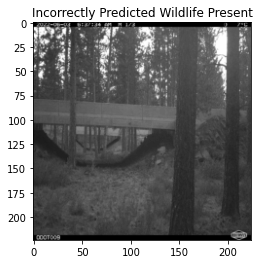

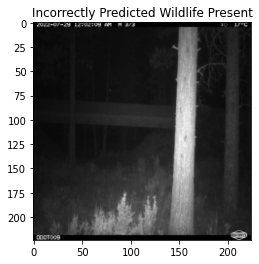

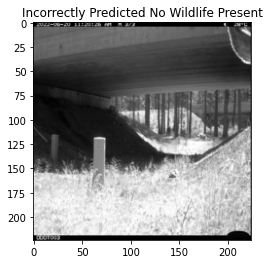

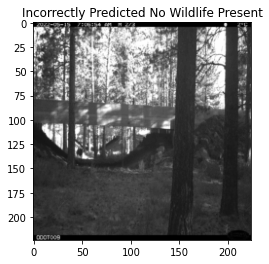

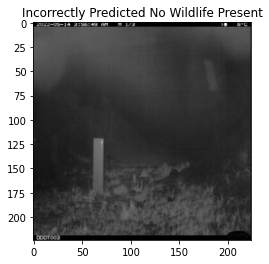

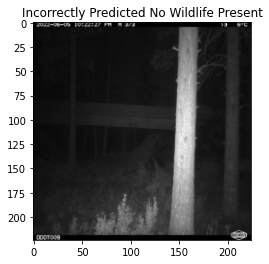

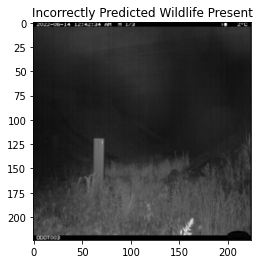

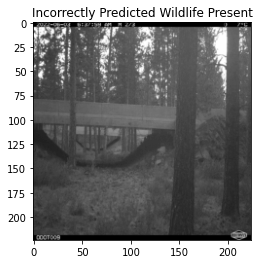

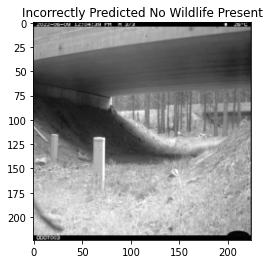

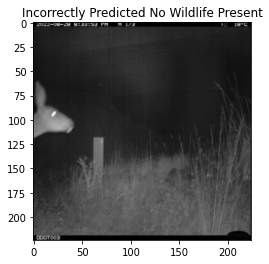

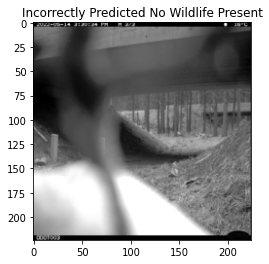

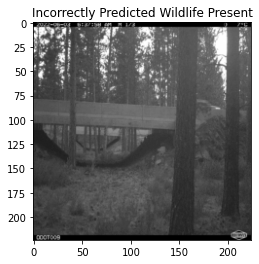

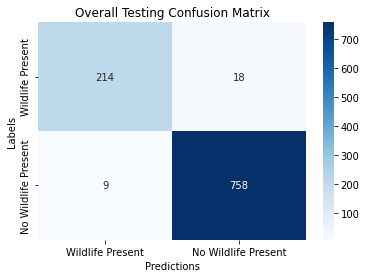

Overall Accuracy: 0.972972972972973
Overall Precision: 0.9596412556053812
Overall Recall: 0.9224137931034483
Overall F-Score: 0.9406593406593406


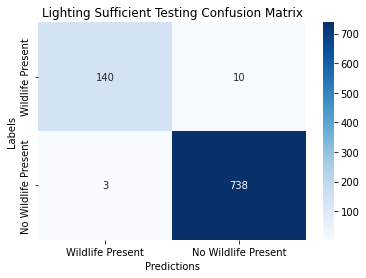

Lighting Sufficient Accuracy: 0.9854096520763187
Lighting Sufficient Precision: 0.9790209790209791
Lighting Sufficient Recall: 0.9333333333333333
Lighting Sufficient F-Score: 0.9556313993174061


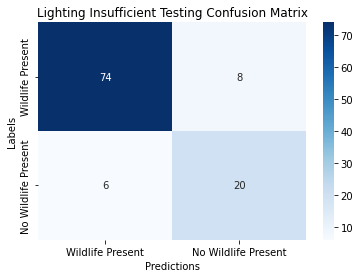

Lighting Insufficient Accuracy: 0.8703703703703703
Lighting Insufficient Precision: 0.925
Lighting Insufficient Recall: 0.9024390243902439
Lighting Insufficient F-Score: 0.9135802469135802


In [9]:
train_and_test_ResNet50(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes)


Training and Testing ResNet152
epoch: 0
training loss: 0.05533253992251798 and training accuracy: 0.8805073431241656
testing loss: 0.013755717070062866 and testing accuracy: 0.953953953953954
epoch: 1
training loss: 0.00883711945946771 and training accuracy: 0.9659546061415221
testing loss: 0.010498817103707024 and testing accuracy: 0.9569569569569569
epoch: 2
training loss: 0.006388869294428107 and training accuracy: 0.9736315086782377
testing loss: 0.007827794404459876 and testing accuracy: 0.968968968968969
epoch: 3
training loss: 0.003970324690360452 and training accuracy: 0.982977303070761
testing loss: 0.007492943892684962 and testing accuracy: 0.968968968968969
epoch: 4
training loss: 0.0037670519643157622 and training accuracy: 0.9853137516688919
testing loss: 0.011066762961270576 and testing accuracy: 0.968968968968969
epoch: 5
training loss: 0.0025617872603672515 and training accuracy: 0.9916555407209613
testing loss: 0.007635288372922743 and testing accuracy: 0.975975975975

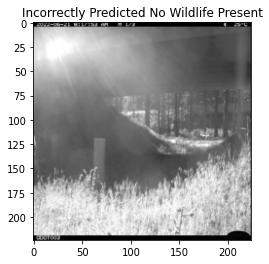

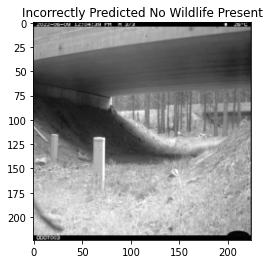

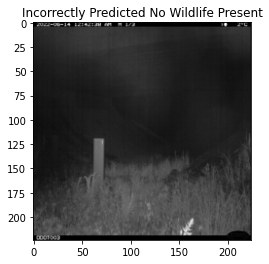

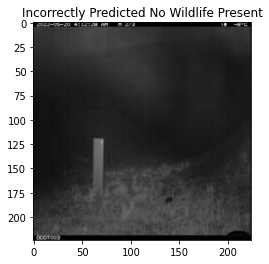

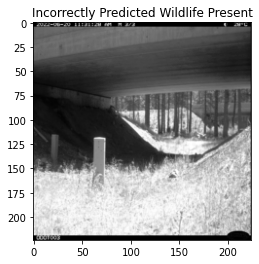

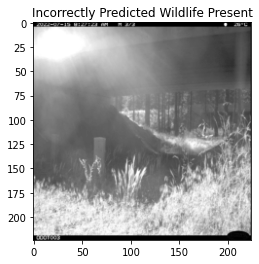

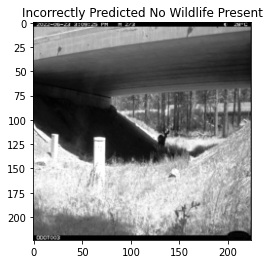

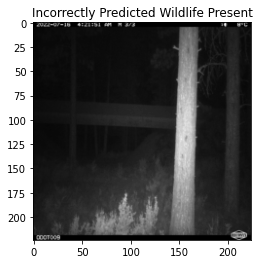

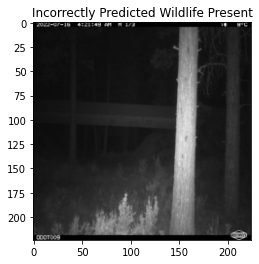

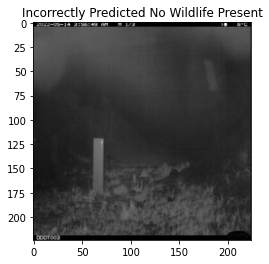

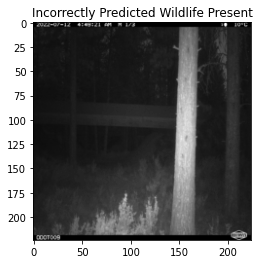

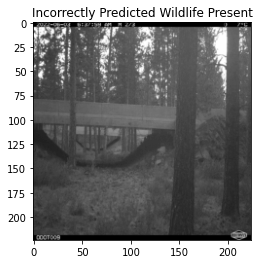

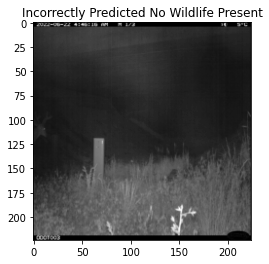

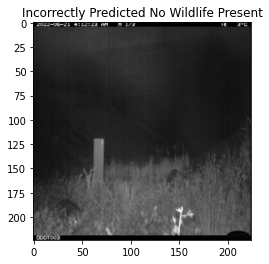

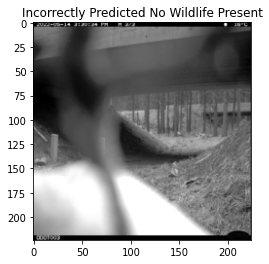

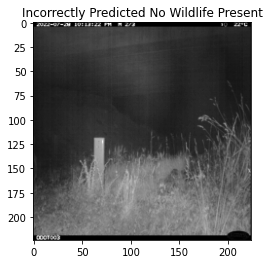

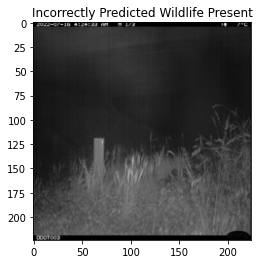

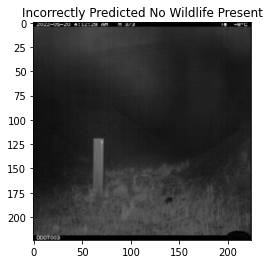

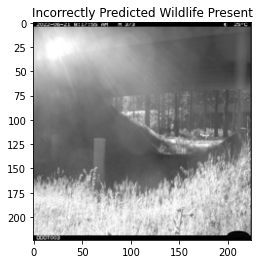

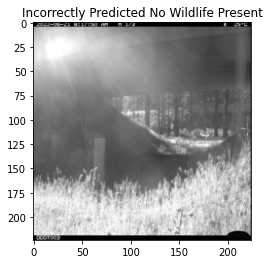

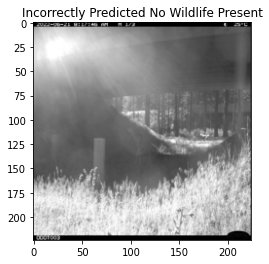

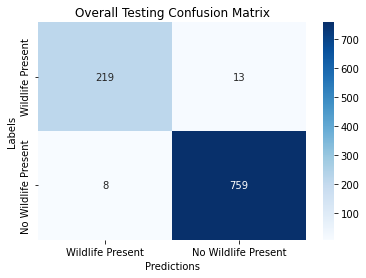

Overall Accuracy: 0.978978978978979
Overall Precision: 0.9647577092511013
Overall Recall: 0.9439655172413793
Overall F-Score: 0.954248366013072


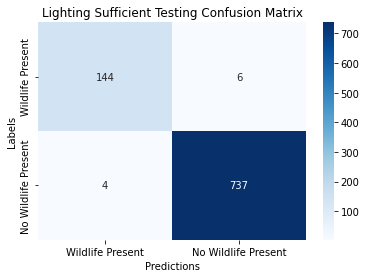

Lighting Sufficient Accuracy: 0.9887766554433222
Lighting Sufficient Precision: 0.972972972972973
Lighting Sufficient Recall: 0.96
Lighting Sufficient F-Score: 0.9664429530201343


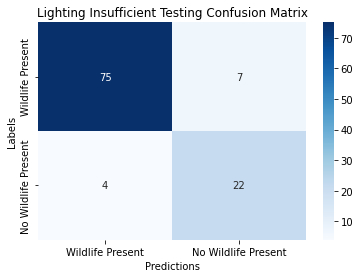

Lighting Insufficient Accuracy: 0.8981481481481481
Lighting Insufficient Precision: 0.9493670886075949
Lighting Insufficient Recall: 0.9146341463414634
Lighting Insufficient F-Score: 0.9316770186335404


In [11]:
train_and_test_ResNet152(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes)


Training and Testing Vision Transformer Large 16


Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16-852ce7e3.pth


  0%|          | 0.00/1.13G [00:00<?, ?B/s]

epoch: 0
training loss: 0.027923795155182545 and training accuracy: 0.920894526034713
testing loss: 0.010108410162516535 and testing accuracy: 0.9529529529529529
epoch: 1
training loss: 0.006857580993762358 and training accuracy: 0.9753004005340454
testing loss: 0.008698726015573775 and testing accuracy: 0.965965965965966
epoch: 2
training loss: 0.004818094717639143 and training accuracy: 0.9823097463284379
testing loss: 0.0054606857178317895 and testing accuracy: 0.97997997997998
epoch: 3
training loss: 0.0031528690268373643 and training accuracy: 0.9889853137516689
testing loss: 0.005889403224884902 and testing accuracy: 0.977977977977978
epoch: 4
training loss: 0.0019938315027024115 and training accuracy: 0.9913217623497997
testing loss: 0.007455915327553483 and testing accuracy: 0.9719719719719719
epoch: 5
training loss: 0.0016910068169094792 and training accuracy: 0.9936582109479306
testing loss: 0.008890909199667053 and testing accuracy: 0.975975975975976
epoch: 6
training loss: 

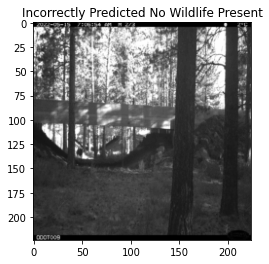

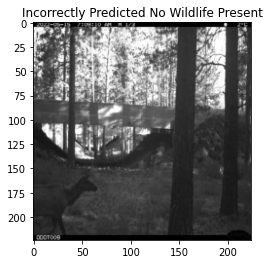

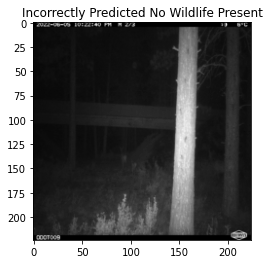

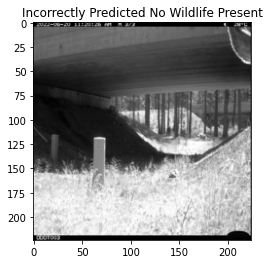

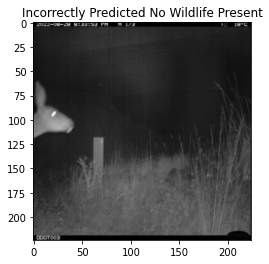

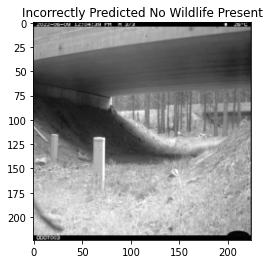

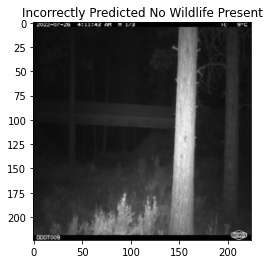

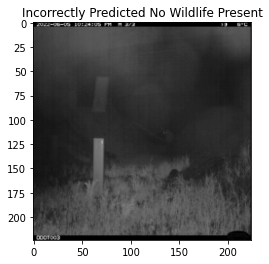

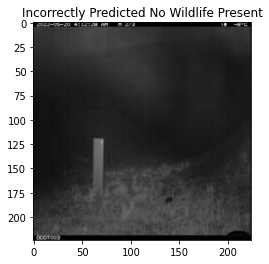

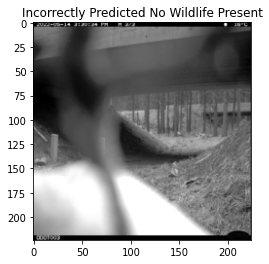

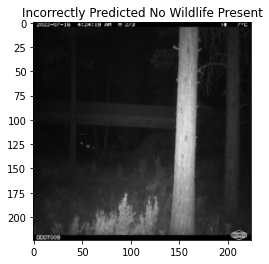

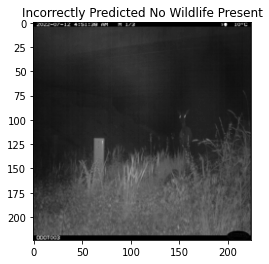

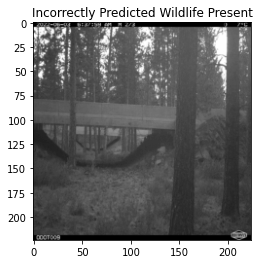

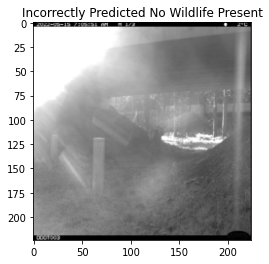

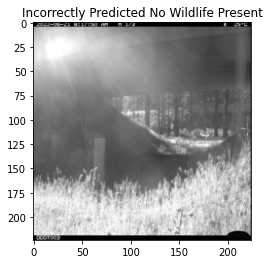

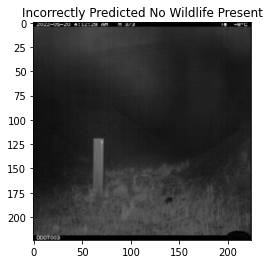

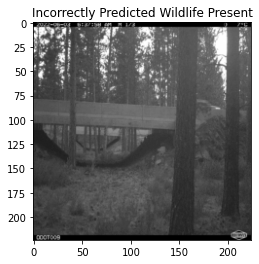

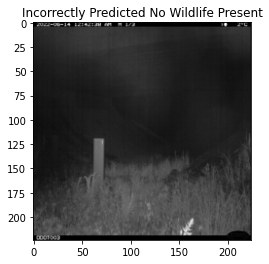

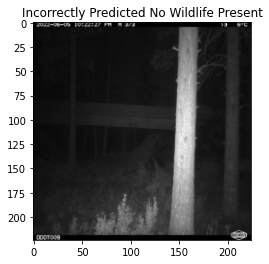

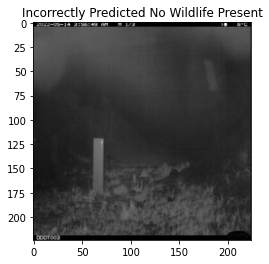

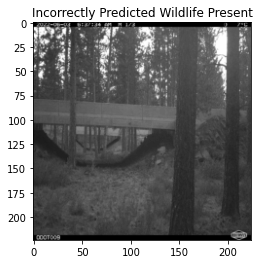

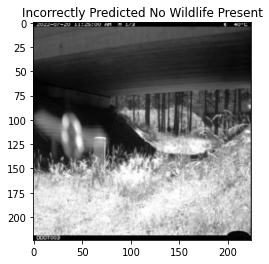

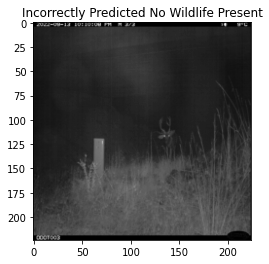

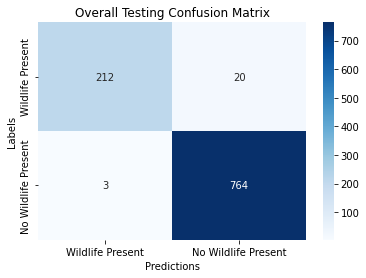

Overall Accuracy: 0.9769769769769769
Overall Precision: 0.986046511627907
Overall Recall: 0.9137931034482759
Overall F-Score: 0.9485458612975392


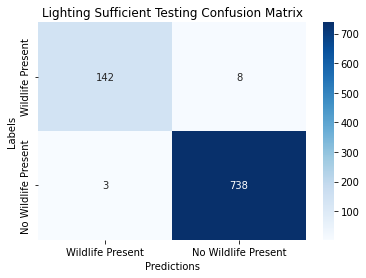

Lighting Sufficient Accuracy: 0.9876543209876543
Lighting Sufficient Precision: 0.9793103448275862
Lighting Sufficient Recall: 0.9466666666666667
Lighting Sufficient F-Score: 0.9627118644067797


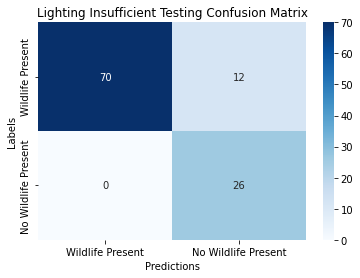

Lighting Insufficient Accuracy: 0.8888888888888888
Lighting Insufficient Precision: 1.0
Lighting Insufficient Recall: 0.8536585365853658
Lighting Insufficient F-Score: 0.9210526315789475


In [12]:
train_and_test_ViT_L_16(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes)